# Importing libraries

In [2]:
from collections import defaultdict
import os
import h5py
import numpy as np
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.utilities.model_summary import ModelSummary
import wandb
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path
import zipfile
from utils import load_fmri, align_features_and_fmri_samples, align_features_and_fmri_samples_friends_s7, CosineLRSchedulerWithWarmup, calculate_metrics


# Dataset Class for Stimulus-fMRI Alignment

A dataset class that aligns stimulus feature embeddings with fMRI data.

## Parameters

- **features_dir** : *str*
    Directory containing stimulus features from the HuggingFace dataset
- **fmri_dir** : *str*
    Directory containing fMRI data from the Algonauts 2025 competition  
- **movies** : *list*
    List of movies to use for training
- **subject** : *int*
    Subject ID number
- **excluded_samples_start** : *int, default=5*
    Number of samples to exclude from the start
- **excluded_samples_end** : *int, default=5*
    Number of samples to exclude from the end
- **hrf_delay** : *int, default=3*
    Hemodynamic response function delay
- **stimulus_window** : *int, default=5*
    Size of the stimulus window


In [3]:
class AlgonautsDataset(Dataset):
    def __init__(self, features_dir, fmri_dir, movies, subject, excluded_samples_start=5, excluded_samples_end=5, hrf_delay=3, stimulus_window=5):
        self.features_dir = features_dir
        self.fmri_dir = fmri_dir
        self.movies = movies
        self.subject = subject
        self.excluded_samples_start = excluded_samples_start
        self.excluded_samples_end = excluded_samples_end
        self.hrf_delay = hrf_delay
        self.stimulus_window = stimulus_window
        self.partition_indices = defaultdict(list)
        
        # First load all raw features
        stimuli_features = {"visual": {}, "audio": {}, "language": {}}
        # Load audio and video features first
        for movie in self.movies:
            if 'friends' in movie:
                season = movie.split('-')[1]
                dir_list = sorted(os.listdir(self.features_dir['audio'] + 'audio')) #List of all audio for each subset of dataset
                for episode in dir_list:
                    if f"{season}e" in episode and '_features_' in episode:
                        episode_base = episode.split('_features_')[0] # friends_s01e01 and so on....
                        
                        for modality in ['audio', 'visual']:
                            with h5py.File(os.path.join(self.features_dir[modality], modality, f"{episode_base}_features_{modality}.h5"), 'r') as f:
                                try:
                                    if modality == 'audio':
                                        stimuli_features[modality][episode_base.split('_')[1]] = f[episode_base.split('_')[1]][modality][:]
                                    else:
                                        stimuli_features[modality][episode_base.split('_')[1]] = f[modality][:]
                                except:
                                    f.visit(lambda x: print(x))
                lang_dir_list = sorted(os.listdir(self.features_dir['language'] + 'language'))
                for episode in lang_dir_list:
                    if f"{season}e" in episode and '_features_' in episode:
                        episode_base = episode.split('_features_')[0]
                        
                        with h5py.File(os.path.join(self.features_dir['language'], 'language', f"{episode_base}_features_language.h5"), 'r') as f:
                            try:
                                st_season_episode = episode_base.split('_')[1]
                                stimuli_features['language'][st_season_episode] = f[st_season_episode]['language_pooler_output'][:]
                            except:
                                f.visit(lambda x: print(x))
            else:
                movie_name = movie.replace('movie10-', '')
                partitions = sorted([f for f in os.listdir(self.features_dir['audio'] + 'audio') if movie_name in f and '_features_' in f])
                
                for partition in partitions:
                    partition_base = partition.split('_features_')[0]
                    
                    for modality in ['audio', 'visual']:
                        with h5py.File(os.path.join(self.features_dir[modality], modality, f"{partition_base}_features_{modality}.h5"), 'r') as f:
                            try:
                                if modality == 'audio':
                                    stimuli_features[modality][partition_base] = f[partition_base][modality][:]
                                else:
                                    stimuli_features[modality][partition_base] = f[modality][:]
                            except:
                                f.visit(lambda x: print(x))
                lang_partitions = sorted([f for f in os.listdir(self.features_dir['language'] + 'language') if movie_name in f and '_features_' in f])
                
                for partition in lang_partitions:
                    partition_base = partition.split('_features_')[0]
                    
                    with h5py.File(os.path.join(self.features_dir['language'], 'language', f"{partition_base}_features_language.h5"), 'r') as f:
                        try:
                            stimuli_features['language'][partition_base] = f[partition_base]['language_pooler_output'][:]
                        except:
                            f.visit(lambda x: print(x))

        fmri_data = load_fmri(self.fmri_dir, self.subject)
        self.raw_stimuli = stimuli_features

        self.aligned_features, self.aligned_fmri = align_features_and_fmri_samples(
            stimuli_features, 
            fmri_data, 
            self.excluded_samples_start, 
            self.excluded_samples_end, 
            self.hrf_delay, 
            self.stimulus_window, 
            self.movies
        )

    def __len__(self):
        return self.aligned_features['audio'].shape[0]

    def __getitem__(self, idx):
        return {
            'audio': self.aligned_features['audio'][idx],
            'video': self.aligned_features['visual'][idx],
            'language': self.aligned_features['language'][idx],
            'fmri': self.aligned_fmri[idx]
        }
    
    def get_raw_stimuli(self):
        return self.raw_stimuli
   

In [4]:
visual_dir = '/home/pranav/mihir/algonauts_challenge/AlgonautsDS-features/features/cosmos/tokens'
audio_dir = '/home/pranav/mihir/algonauts_challenge/AlgonautsDS-features/developer_kit/stimulus_features/raw/'
language_dir = '/home/pranav/mihir/algonauts_challenge/AlgonautsDS-features/developer_kit/stimulus_features/raw/'
features_dir = {"visual": visual_dir, "audio": audio_dir, "language": language_dir}
fmri_dir = '/home/pranav/mihir/algonauts_challenge/algonauts_2025.competitors/fmri/'
# movies_train = ["friends-s01"]
movies_train = ["friends-s01", "friends-s02", "friends-s03", "friends-s04", "friends-s05"]
# movies_train = ["friends-s01", "friends-s02", "friends-s03", "friends-s04", "friends-s05", "movie10-bourne", "movie10-figures", "movie10-life", "movie10-wolf"]
movies_val = ["friends-s06"]
modality = "all"  #@param ["visual", "audio", "language", "all"]

excluded_samples_start = 5  #@param {type:"slider", min:0, max:20, step:1}
excluded_samples_end = 5  #@param {type:"slider", min:0, max:20, step:1}
hrf_delay = 3  #@param {type:"slider", min:0, max:10, step:1}
stimulus_window = 5

subject = 1 #@param ["1", "2", "3", "5"] {type:"raw", allow-input: true}

train_ds = AlgonautsDataset(features_dir, fmri_dir, movies=movies_train, subject=subject, excluded_samples_start=excluded_samples_start, excluded_samples_end=excluded_samples_end, hrf_delay=hrf_delay, stimulus_window=stimulus_window)
val_ds = AlgonautsDataset(features_dir, fmri_dir, movies=movies_val, subject=subject, excluded_samples_start=excluded_samples_start, excluded_samples_end=excluded_samples_end, hrf_delay=hrf_delay, stimulus_window=stimulus_window)

In [5]:
print("Train dataset length: ", len(train_ds))
print("Validation dataset length: ", len(val_ds))

Train dataset length:  112069
Validation dataset length:  22924


In [8]:
with h5py.File("/home/pranav/mihir/algonauts_challenge/AlgonautsDS-features/features/cosmos/tokens/visual/friends_s01e01a_features_visual.h5") as f:
    print(f['visual'][:].shape)

(591, 2, 16, 16)


# Start Building Your Model Here

The data is now prepared - you can begin implementing your model architecture and training pipeline below.

In [6]:
print(train_ds[0]['audio'].shape)
print(train_ds[0]['video'].shape)
print(train_ds[0]['language'].shape)
print(train_ds[0]['fmri'].shape)


(5, 128)
(5, 2, 16, 16)
(768,)
(1000,)


In [9]:
import sys
sys.path.append("/home/pranav/mihir/cosmos-predict1")
from cosmos_predict1.tokenizer.inference.video_lib import CausalVideoTokenizer
ckpt_path = "/home/pranav/mihir/cosmos-predict1/checkpoints/Cosmos-Tokenize1-DV8x16x16-720p/decoder.jit"
tokenizer = CausalVideoTokenizer(
        checkpoint_dec=ckpt_path,
        device="cuda",
        dtype="bfloat16"
    )

In [10]:
tokenizer

CausalVideoTokenizer(
  (_dec_model): RecursiveScriptModule(
    original_name=Sequential
    (inv_quant): RecursiveScriptModule(
      original_name=InvQuantizerJit
      (quantizer): RecursiveScriptModule(
        original_name=FSQuantizer
        (project_in): RecursiveScriptModule(original_name=Identity)
        (project_out): RecursiveScriptModule(original_name=Identity)
      )
    )
    (post_quant_conv): RecursiveScriptModule(
      original_name=CausalConv3d
      (conv3d): RecursiveScriptModule(original_name=Conv3d)
    )
    (decoder): RecursiveScriptModule(
      original_name=DecoderFactorized
      (unpatcher3d): RecursiveScriptModule(original_name=UnPatcher3D)
      (conv_in): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=CausalConv3d
          (conv3d): RecursiveScriptModule(original_name=Conv3d)
        )
        (1): RecursiveScriptModule(
          original_name=CausalConv3d
          (conv3d): Rec

In [6]:
train_ds[0].keys()

dict_keys(['audio', 'video', 'language', 'fmri'])

In [12]:
class FMRIPredictor(L.LightningModule):
    def __init__(self, config: dict):
        """
        Initialize the fMRI prediction model.
        
        Args:
            V (int): Vocabulary size of fMRI tokens (default: 1000).
            learning_rate (float): Learning rate for the optimizer (default: 1e-3).
        """
        super().__init__()
        self.out_features = config['out_features']  # Vocabulary size
        self.learning_rate = config['learning_rate']
        
        # Audio processing: LSTM to summarize sequence
        self.audio_lstm = nn.LSTM(
            input_size=128, 
            hidden_size=256, 
            num_layers=1, 
            batch_first=True
        )
        
        # Video processing: Reduce dimensionality, then LSTM
        self.video_linear = nn.Linear(8192, 512)
        self.video_lstm = nn.LSTM(
            input_size=512, 
            hidden_size=512, 
            num_layers=1, 
            batch_first=True
        )
        
        # Text processing: Project to common dimension
        self.text_linear = nn.Linear(768, 512)
        
        # Project audio output to match dimension (512)
        self.audio_proj = nn.Linear(256, 512)
        
        # Learnable CLS token for fusion
        self.cls_token = nn.Parameter(torch.randn(1, 512))
        
        # Transformer encoder for modality fusion
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=512, 
                nhead=8, 
                dim_feedforward=2048, 
                dropout=0.1
            ), 
            num_layers=1
        )
        
        # Prediction head: Output logits for 32 tokens
        self.pred_head = nn.Linear(512, self.out_features)
        self.max_lr = config['learning_rate']
        self.min_lr = config['learning_rate'] * 0.01
        self.warmup_steps = config['warmup_steps']
        self.weight_decay = config['weight_decay']

        self.save_hyperparameters()
    
    def forward(self, audio, video, text):
        batch_size = audio.size(0)
        
        # Step 1: Detect samples where text is missing (contains NaN)
        text_missing = torch.isnan(text).any(dim=1)  # Shape: (batch_size,)
        
        # Step 2: Replace NaN in text with zeros to avoid propagation
        text = torch.nan_to_num(text, nan=0.0)  # Shape: (batch_size, 768)
        
        # Step 3: Process audio sequence
        _, (audio_hidden, _) = self.audio_lstm(audio)  # (1, batch_size, 256)
        audio_summary = audio_hidden[-1]  # (batch_size, 256)
        audio_summary = self.audio_proj(audio_summary)  # (batch_size, 512)
        
        # Step 4: Process video sequence
        video_reduced = self.video_linear(video)  # (batch_size, 5, 512)
        _, (video_hidden, _) = self.video_lstm(video_reduced)  # (1, batch_size, 512)
        video_summary = video_hidden[-1]  # (batch_size, 512)
        
        # Step 5: Project text embedding to common dimension
        text_proj = self.text_linear(text)  # (batch_size, 512)
        
        # Step 6: Prepare input for fusion with a CLS token
        cls_token = self.cls_token.expand(batch_size, -1)  # (batch_size, 512)
        fusion_input = torch.stack(
            [cls_token, audio_summary, video_summary, text_proj], 
            dim=1
        )  # (batch_size, 4, 512)
        
        # Step 7: Create attention mask to ignore text when missing
        attn_mask = torch.zeros(batch_size, 4, dtype=torch.bool, device=audio.device)
        attn_mask[:, 3] = text_missing  # Mask text position (index 3) if NaN was present
        
        # Step 8: Fuse modalities with Transformer encoder
        fusion_output = self.transformer_encoder(
            fusion_input.transpose(0, 1),  # (4, batch_size, 512)
            src_key_padding_mask=attn_mask
        )  # (4, batch_size, 512)
        cls_output = fusion_output[0]  # (batch_size, 512)
        assert not torch.isnan(cls_output).any(), "CLS output contains NaN values"
        # Step 9: Predict fMRI tokens
        pred = self.pred_head(cls_output)  # (batch_size, out_features)
        return pred
    
    def training_step(self, batch, batch_idx):
        """
        Training step: Compute loss for a batch.
        """
        audio, video, text, fmri_tokens = batch['audio'], batch['video'], batch['language'], batch['fmri']
        logits = self(audio, video, text)  # (batch_size, 32, V)
        # CrossEntropyLoss expects (N, C) and (N,) targets
        # loss = F.cross_entropy(logits.view(-1, self.V), fmri_tokens.view(-1))
        mae, mse, r2, pearson_r, _ = calculate_metrics(
            pred=logits,
            target=fmri_tokens,
        )
        self.log('train/loss', mse, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train/mae', mae, on_step=True, on_epoch=True, prog_bar=False)
        self.log('train/r2', r2, on_step=True, on_epoch=True, prog_bar=False)
        self.log('train/pearson_r', pearson_r, on_step=True, on_epoch=True, prog_bar=False)
        return mse
    
    def validation_step(self, batch, batch_idx):
        """
        Validation step: Compute loss for validation.
        """
        audio, video, text, fmri_tokens = batch['audio'], batch['video'], batch['language'], batch['fmri']
        logits = self(audio, video, text)
        # loss = F.cross_entropy(logits.view(-1, self.V), fmri_tokens.view(-1))
        loss = F.mse_loss(logits, fmri_tokens)
        mae, mse, r2, pearson_r, fig = calculate_metrics(
            pred=logits,
            target=fmri_tokens,
        )

        # if batch_idx == 0:
        #     self.logger.experiment.log({
        #         "val/pearson_r": pearson_r,
        #         "val/mae": mae,
        #         "val/r2": r2,
        #         "val/loss": loss,
        #         "val/reconstruction": fig,
        #         "global_step": self.global_step,
        #     })
        # else:
        self.log('val/loss', loss, on_epoch=True, prog_bar=True)
        self.log('val/mae', mae, on_epoch=True, prog_bar=False)
        self.log('val/r2', r2, on_epoch=True, prog_bar=False)
        self.log('val/pearson_r', pearson_r, on_epoch=True, prog_bar=False)


    
    def configure_optimizers(self):
        """
        Configure the optimizer.
        """
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
            betas=(0.9, 0.95),
            eps=1e-8,
        )
        
        # Linear learning rate decay
        scheduler = CosineLRSchedulerWithWarmup(
            optimizer,
            max_lr=self.max_lr,
            min_lr=self.min_lr,
            warmup_steps=self.warmup_steps,
            max_steps=self.trainer.estimated_stepping_batches,
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            },
        }
    

In [13]:
# config = {
#     'out_features': 1000,
#     'learning_rate': 1e-4,
#     'warmup_steps': 5000,
#     'weight_decay': 0.01
# }
# model = FMRIPredictor(config)
# audio = torch.randn(4, 5, 128)
# video = torch.randn(4, 5, 8192)
# text = torch.randn(4, 768)
# # text_mask = torch.randint(0, 2, (4,))
# # fmri_tokens = torch.randint(0, 1000, (1, 32))
# out = model(audio, video, text)
# print("fmri tokens shape: ", out.shape)
ckpt= "/home/pranav/mihir/algonauts_challenge/algonauts2025/checkpoints/lstm_transformer_baseline/step=40480-val_pearson_r=0.0000.ckpt"
model = FMRIPredictor.load_from_checkpoint(ckpt)

/home/pranav/miniconda3/envs/fmri/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [18]:
project = "algonauts2025"
run_name = "lstm_transformer_baseline"
wandb_logger = WandbLogger(
    project=project,
    name=run_name,
    dir="/home/pranav/mihir/algonauts_challenge/algonauts2025/wandb_logs"
)
checkpoint_callback = ModelCheckpoint(
    dirpath=f'/home/pranav/mihir/algonauts_challenge/algonauts2025/checkpoints/{run_name}',
    filename='{step:04d}-{val_pearson_r:.4f}',
    monitor='val/pearson_r',
    mode='max',
    save_top_k=1,
    save_last=True,
)

early_stopping = EarlyStopping(
    monitor='val/pearson_r',
    patience=5,
    mode='max',
    verbose=True,
    min_delta=1e-4
)

In [19]:
train_loader = DataLoader(train_ds,
                          batch_size=32, 
                          num_workers=8,
                          pin_memory=True, 
                          prefetch_factor=2,
                          persistent_workers=True
                    )

val_loader = DataLoader(val_ds, 
                        batch_size=32, 
                        num_workers=8, 
                        pin_memory=True, 
                        prefetch_factor=2, 
                        persistent_workers=True
                    )


In [20]:
torch.set_float32_matmul_precision('high')
summary = ModelSummary(model, max_depth=2)
print(summary)

  | Name                       | Type               | Params | Mode 
--------------------------------------------------------------------------
0 | audio_lstm                 | LSTM               | 395 K  | train
1 | video_linear               | Linear             | 4.2 M  | train
2 | video_lstm                 | LSTM               | 2.1 M  | train
3 | text_linear                | Linear             | 393 K  | train
4 | audio_proj                 | Linear             | 131 K  | train
5 | transformer_encoder        | TransformerEncoder | 3.2 M  | train
6 | transformer_encoder.layers | ModuleList         | 3.2 M  | train
7 | pred_head                  | Linear             | 513 K  | train
--------------------------------------------------------------------------
10.9 M    Trainable params
0         Non-trainable params
10.9 M    Total params
43.530    Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


In [21]:
debug = True
trainer = L.Trainer(
    accelerator='auto',
    devices=1,
    max_epochs=10,
    callbacks=[checkpoint_callback, early_stopping],
    logger=wandb_logger if not debug else None,
    precision='bf16-mixed',
    log_every_n_steps=1,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | audio_lstm          | LSTM               | 395 K  | train
1 | video_linear        | Linear             | 4.2 M  | train
2 | video_lstm          | LSTM               | 2.1 M  | train
3 | text_linear         | Linear             | 393 K  | train
4 | audio_proj          | Linear             | 131 K  | train
5 | transformer_encoder | TransformerEncoder | 3.2 M  | train
6 | pred_head           | Linear             | 513 K  | train
  | other params        | n/a                | 512    | n/a  
-------------------------------------------------------------------
10.9 M    Trainable params
0         Non-trainable params
10.9 M    Total params
43.530    Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70c0c358b7f0>
Traceback (most recent call last):
  File "/home/pranav/miniconda3/envs/fmri/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/pranav/miniconda3/envs/fmri/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/pranav/miniconda3/envs/fmri/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/pranav/miniconda3/envs/fmri/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/pranav/miniconda3/envs/fmri/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/pranav/miniconda3/envs/fmri/lib/python3.10/selectors.py", line 416, in select
    fd_

AssertionError: CLS output contains NaN values

<Figure size 2000x1000 with 0 Axes>

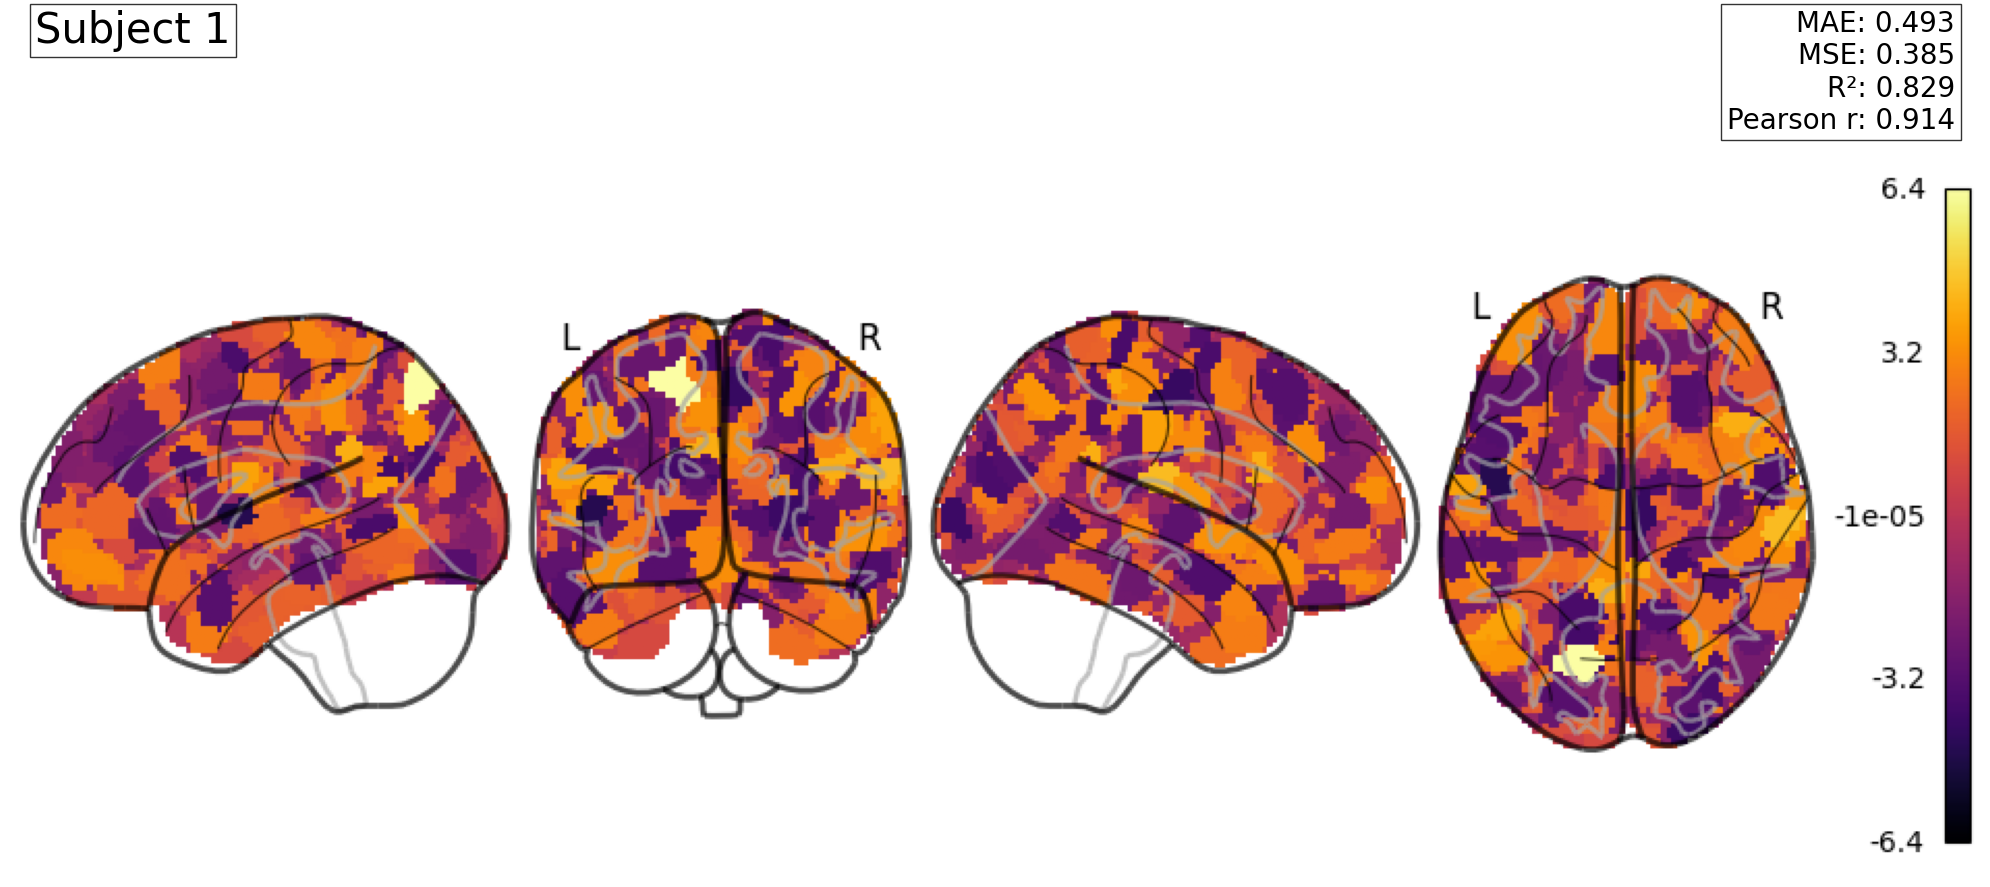

In [1]:
from utils import calculate_metrics
atlas_path = "/home/pranav/mihir/algonauts_challenge/algonauts_2025.competitors/fmri/sub-01/atlas/sub-01_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-dseg_parcellation.nii.gz"
subject = 1
import numpy as np
import torch

def test_brain_visualization(atlas_path, subject):
    # Create sample predictions and targets
    np.random.seed(42)
    base = np.random.randn(1000)
    noise1 = np.random.randn(1000) * 0.3
    noise2 = np.random.randn(1000) * 0.3
    
    # Create correlated but different data
    pred = torch.tensor(base + noise1, dtype=torch.float32)
    target = torch.tensor(base + noise2, dtype=torch.float32)
    
    # Normalize to typical fMRI value ranges (-2 to 2)
    pred = (pred - pred.mean()) / pred.std() * 1.5
    target = (target - target.mean()) / target.std() * 1.5
    
    # Calculate metrics and get visualization
    # atlas_path = '/home/pranav/mihir/algonauts_challenge/algonauts_2025.competitors/data/sub-01/atlas/sub-01_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-dseg_parcellation.nii.gz'
    mae, mse, r2, pearson_r, fig = calculate_metrics(
        pred=pred,
        target=target,
        atlas_path=atlas_path,
        subject=subject
    )
    
    # Just show the figure without any additional printouts
    if fig is not None:
        import matplotlib.pyplot as plt
        plt.show()

test_brain_visualization(atlas_path, subject)

# Run inference on trained model

Friends Season 7 is the test set. Its corresponding fMRI data is withheld.

In [6]:
movies_test = ["friends-s07"] 
test_ds = AlgonautsDataset(features_dir, fmri_dir, movies=movies_test, subject=subject, excluded_samples_start=excluded_samples_start, excluded_samples_end=excluded_samples_end, hrf_delay=hrf_delay, stimulus_window=stimulus_window)
test_stimuli = test_ds.get_raw_stimuli()

In [7]:
for key_modality, value_modality in test_stimuli.items():
    print(f"\n{key_modality} features movie names and shape:")
    for key_movie, value_movie in value_modality.items():
        print(key_movie + " " + str(value_movie.shape))


visual features movie names and shape:
s07e01a (460, 8192)
s07e01b (494, 8192)
s07e02a (492, 8192)
s07e02b (526, 8192)
s07e03a (418, 8192)
s07e03b (452, 8192)
s07e04a (448, 8192)
s07e04b (482, 8192)
s07e05a (454, 8192)
s07e05b (488, 8192)
s07e06a (478, 8192)
s07e06b (513, 8192)
s07e07a (473, 8192)
s07e07b (507, 8192)
s07e08a (475, 8192)
s07e08b (509, 8192)
s07e09a (451, 8192)
s07e09b (485, 8192)
s07e10a (460, 8192)
s07e10b (494, 8192)
s07e11a (465, 8192)
s07e11b (499, 8192)
s07e12a (452, 8192)
s07e12b (487, 8192)
s07e13a (540, 8192)
s07e13b (574, 8192)
s07e14a (467, 8192)
s07e14b (501, 8192)
s07e15a (567, 8192)
s07e15b (601, 8192)
s07e16a (398, 8192)
s07e16b (402, 8192)
s07e16c (432, 8192)
s07e17a (433, 8192)
s07e17b (468, 8192)
s07e18a (477, 8192)
s07e18b (512, 8192)
s07e19a (437, 8192)
s07e19b (471, 8192)
s07e20a (454, 8192)
s07e20b (488, 8192)
s07e21a (430, 8192)
s07e21b (464, 8192)
s07e22a (472, 8192)
s07e22b (506, 8192)
s07e23a (481, 8192)
s07e23b (485, 8192)
s07e23c (485, 8192)


In [9]:
aligned_features_friends_s7 = align_features_and_fmri_samples_friends_s7(
    test_stimuli, fmri_dir)

# As an example, print the shape of the stimulus features of one episode for
# each subject
for key, val in aligned_features_friends_s7.items():
    episode_name = "s07e01a"
    example_episode_shape_visual = val[episode_name]['visual'].shape
    example_episode_shape_audio = val[episode_name]['audio'].shape
    example_episode_shape_language = val[episode_name]['language'].shape
    print(f"Subject: {key}")
    print(f"  Episode: {episode_name} - visual features shape: {example_episode_shape_visual}")
    print(f"  Episode: {episode_name} - audio features shape: {example_episode_shape_audio}")
    print(f"  Episode: {episode_name} - language features shape: {example_episode_shape_language}")
    print("-" * 40)

Aligning stimulus and fMRI features of the four subjects: 100%|██████████| 4/4 [00:08<00:00,  2.25s/it]

Subject: sub-01
  Episode: s07e01a - visual features shape: (460, 5, 8192)
  Episode: s07e01a - audio features shape: (460, 5, 128)
  Episode: s07e01a - language features shape: (460, 768)
----------------------------------------
Subject: sub-02
  Episode: s07e01a - visual features shape: (460, 5, 8192)
  Episode: s07e01a - audio features shape: (460, 5, 128)
  Episode: s07e01a - language features shape: (460, 768)
----------------------------------------
Subject: sub-03
  Episode: s07e01a - visual features shape: (460, 5, 8192)
  Episode: s07e01a - audio features shape: (460, 5, 128)
  Episode: s07e01a - language features shape: (460, 768)
----------------------------------------
Subject: sub-05
  Episode: s07e01a - visual features shape: (460, 5, 8192)
  Episode: s07e01a - audio features shape: (460, 5, 128)
  Episode: s07e01a - language features shape: (460, 768)
----------------------------------------


In [14]:
submission_predictions = {}

# Loop through each subject
desc = "Predicting fMRI responses of each subject"
for sub, features in tqdm(aligned_features_friends_s7.items(), desc=desc):

    # Initialize the nested dictionary for each subject's predictions
    submission_predictions[sub] = {}

    # Loop through each Friends season 7 episode
    for epi, feat_epi in features.items():

        # convert the predictions to float32
        video = torch.tensor(feat_epi['visual']).cuda()
        audio = torch.tensor(feat_epi['audio']).cuda()
        text = torch.tensor(feat_epi['language']).cuda()
        fmri_pred = model(video=video, audio=audio, text=text).detach().cpu().numpy() #TODO: Replace model with your trained model

        # Store formatted predictions in the nested dictionary
        submission_predictions[sub][epi] = fmri_pred

Predicting fMRI responses of each subject: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


### Upload the zip file to Codabench for eval.

In [16]:
# Select the saving directory
run_name = "lstm_transformer_baseline"
save_dir = Path('saved_preds/') / run_name
os.makedirs(save_dir, exist_ok=True)

# Save the predicted fMRI dictionary as a .npy file
output_file = save_dir / "fmri_predictions_friends_s7.npy"
np.save(output_file, submission_predictions)
print(f"Formatted predictions saved to: {output_file}")

# Zip the saved file for submission
zip_file = save_dir / "fmri_predictions_friends_s7.zip"  # Use / instead of +
with zipfile.ZipFile(zip_file, 'w') as zipf:
    zipf.write(output_file, os.path.basename(output_file))
print(f"Submission file successfully zipped as: {zip_file}")

Formatted predictions saved to: saved_preds/lstm_transformer_baseline/fmri_predictions_friends_s7.npy
Submission file successfully zipped as: saved_preds/lstm_transformer_baseline/fmri_predictions_friends_s7.zip
